In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from alerce.core import Alerce

alerce = Alerce()
import requests

In [2]:
object_id = "ZTF25abcwzci"

In [9]:
# fink https://fink-broker.readthedocs.io/en/latest/services/search/getting_started/#quick-start-api
r = requests.post(
    "https://api.fink-portal.org/api/v1/objects",
    json={"objectId": object_id, "output-format": "json"},
)
pdf_fink = pd.read_json(io.BytesIO(r.content))
# rename TOM MOP OPM
namedic = {1: "ZTF_g", 2: "ZTF_r"}
pdf_fink["filter"] = pdf_fink["i:fid"].map(namedic)
new_pdf_fink = pdf_fink[["i:jd", "filter", "i:magpsf", "i:sigmapsf", "d:mulens"]].copy()
new_pdf_fink = new_pdf_fink.rename(
    columns={"i:jd": "time", "i:magpsf": "magnitude", "i:sigmapsf": "error"}
)
# new_pdf.to_csv("{}.csv".format(pdf["i:objectId"][0]), index=False)

In [29]:
# ALeRCE https://alerce.readthedocs.io/en/latest/tutorials/ztf_api.html#query-lightcurve
# lightcurve = alerce.query_lightcurve(object_id,format="json")
pdf_alerce = pd.DataFrame.from_dict(lightcurve["detections"])
# rename TOM MOP OPM
namedic = {1: "ZTF_g", 2: "ZTF_r"}
pdf_alerce["filter"] = pdf_alerce["fid"].map(namedic)
new_pdf_alerce = pdf_alerce[["mjd", "filter", "magpsf", "sigmapsf"]].copy()
# convert mjd to jd
new_pdf_alerce["mjd"] = new_pdf_alerce["mjd"] + 2400000.5
new_pdf_alerce = new_pdf_alerce.rename(
    columns={"mjd": "time", "magpsf": "magnitude", "sigmapsf": "error"}
)

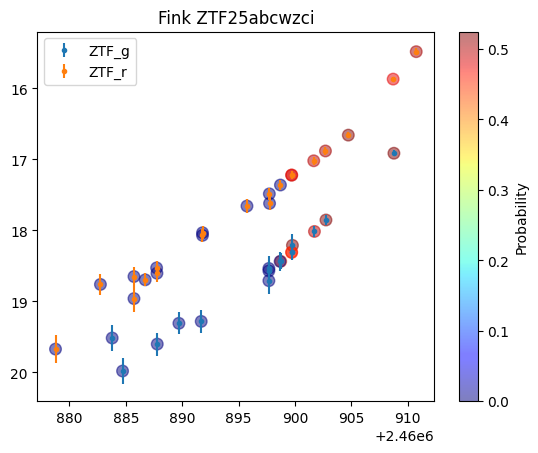

In [30]:
plt.gca().invert_yaxis()
plt.title("Fink {}".format(object_id))
for fid in range(1, 3):
    mask_filt = new_pdf_fink["filter"] == namedic[fid]
    plt.errorbar(
        new_pdf_fink["time"][mask_filt].array,
        new_pdf_fink["magnitude"][mask_filt].array,
        yerr=new_pdf_fink["error"][mask_filt].array,
        fmt=".",
        label=namedic[fid],
    )
    plt.scatter(
        new_pdf_fink["time"][mask_filt].array,
        new_pdf_fink["magnitude"][mask_filt].array,
        c=new_pdf_fink["d:mulens"][mask_filt].array,
        s=70,
        cmap="jet",
        zorder=0,
        alpha=0.5,
    )
cb = plt.colorbar()
cb.set_label("Probability")

plt.legend()

/tmp/ipykernel_16813/3956550433.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


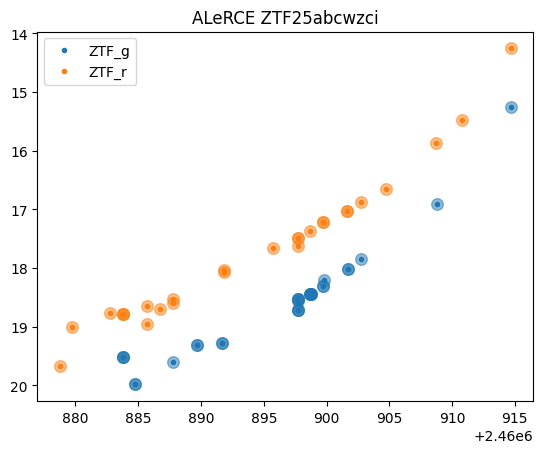

In [31]:
plt.gca().invert_yaxis()
plt.title("ALeRCE {}".format(object_id))
for fid in range(1, 3):
    mask_filt = new_pdf_alerce["filter"] == namedic[fid]
    plt.errorbar(
        new_pdf_alerce["time"][mask_filt].array,
        new_pdf_alerce["magnitude"][mask_filt].array,
        fmt=".",
        label=namedic[fid],
    )
    plt.scatter(
        new_pdf_alerce["time"][mask_filt].array,
        new_pdf_alerce["magnitude"][mask_filt].array,
        s=70,
        cmap="jet",
        zorder=0,
        alpha=0.5,
    )
# cb = plt.colorbar()
# cb.set_label('Probability')

plt.legend()

In [32]:
# %config InlineBackend.figure_formats = ['svg']
import numpy as np
from iminuit import Minuit, cost
from matplotlib import pyplot as plt
from numba_stats import bernstein, norm, t, truncexpon

In [46]:
def pspl_no_blend(x, log10u0, log10te, t0, fs, fb):
    u0 = 10**log10u0
    te = 10**log10te
    usqr = u0**2 + (x - t0) ** 2 / te**2
    return fs * (usqr + 2) / (usqr * (usqr + 4.0)) ** 0.5 + fb


flux = 10.0 ** (-0.4 * new_pdf_alerce["magnitude"][mask_filt].array)
err_flux = np.abs(new_pdf_alerce["error"][mask_filt].array * flux * np.log(10) / 2.5)
guess = (
    np.log10(1),
    np.log10(30.0),
    new_pdf_alerce["time"][mask_filt].array[
        np.argmax(new_pdf_alerce["time"][mask_filt].array - 2450000)
    ]
    - 2450000,
    np.median(flux),
    np.min(flux),
)
print(guess)
c = cost.LeastSquares(
    new_pdf_alerce["time"][mask_filt].array - 2450000, flux, err_flux, pspl_no_blend
)
m = Minuit(c, *guess)

m.migrad()

(0.0, 1.4771212547196624, 10914.6895486, 8.64480497246439e-08, 1.3515421673875382e-08)


/tmp/ipykernel_16813/2088636799.py:4: RuntimeWarning: divide by zero encountered in divide
  usqr = u0**2 + (x - t0) ** 2 / te**2
/tmp/ipykernel_16813/2088636799.py:5: RuntimeWarning: invalid value encountered in divide
  return fs * (usqr + 2) / (usqr * (usqr + 4.0)) ** 0.5 + fb


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.78 (χ²/ndof = 0.9)      │              Nfcn = 862              │
│ EDM = 3.85e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │           ABOVE call limit           │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ log10u0 │  -1.2381  │  0.0000   │            │            │         │         │       │
│ 1 │ log10te │  1.4633   │  0.0000   │            │            │         │         │       │
│ 2 │ t0      │ 1.0915e4  │ 0.0000e4  │            │            │         │         │       │
│ 3 │ fs      │ 1.2455e-7 │ 0.0000e-7 │            │            │         │         │       │
│ 4 │ fb      │-1.3393e-7 │ 0.0000e-7 │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [47]:
10.0 ** m.values["log10te"], 10.0 ** m.values["log10u0"]

(29.062616277202242, 0.05779727746341378)